# Introduction

Data related to stock markets lends itself well to modeling using RNNs due to its sequential nature. We can keep track of opening prices, closing prices, highest prices, and so on for a long period of time as these values are generated every working day. The patterns observed in this data can then be used to predict the future direction in which stock prices are expected to move. Analyzing this data can be interesting in itself, but it also has a financial incentive as accurate predictions can lead to massive profits.

In this notebook, we will try to predict the stock price of AMZN (this is the symbol with which Amazon is referred to in the stock market), using historical data from four companies IBM (IBM), Google (GOOGL), Amazon (AMZN), and Microsoft (MSFT). We use four different companies because they belong to the same sector: Technology. Using data from all four companies may improve the performance of the model. This way, we can capture the broader market sentiment.

The problem statement for this demonstration can be summarized as follows:

> Given the stock prices of Amazon, Google, IBM, and Microsoft for a set number of days, predict the stock price of Amazon after that window.

Let's now look at the data used in this exercise.

# Data Description

You have been provided with four CSV files corresponding to four stocks: AMZN, GOOGL, IBM, and MSFT. The files contain historical data that were gathered from the websites of the stock markets where these companies are listed: NYSE and NASDAQ. The columns in all four files are identical. Let's take a look at them:

- *Date*: The values in this column specify the date on which the values were recorded. In all four files, the dates range from Jaunary 1, 2006 to January 1, 2018.

- *Open*: The values in this column specify the stock price on a given date when the stock market opens.

- *High*: The values in this column specify the highest stock price achieved by a stock on a given date.

- *Low*: The values in this column specify the lowest stock price achieved by a stock on a given date.

- *Close*: The values in this column specify the stock price on a given date when the stock market closes.

- *Volume*: The values in this column specify the total number of shares traded on a given date.

- *Name*: This column gives the official name of the stock as used in the stock market.

There are 3019 records in each data set. The file names are of the format "\<company_name>_stock_data.csv".

# Part 1 - Setup and Data Preparation
In this section, we will:
- Import necessary packages for executing the code
- Load the data
- Prepare the data for further analysis

In [1]:
# Import 'numpy' and 'pandas' for working with numbers and dataframes
import numpy as np
import pandas as pd

# Import 'pyplot' from 'matplotlib' and 'seaborn' for visualizations
from matplotlib import pyplot as plt
import seaborn as sns

# Import 'train_test_split' for data partitioning
from sklearn.model_selection import train_test_split

# Import a scaling method
from sklearn.preprocessing import MinMaxScaler

# Import methods for building and training neural networks
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, SimpleRNN, LSTM, GRU
from tensorflow.keras.optimizers import RMSprop

# Import 'GridSearchCV' for hyperparameter tuning
from sklearn.model_selection import GridSearchCV

# Import 'KerasRegressor' from 'keras' for connecting neural networks with 'sklearn' and 'GridSearchCV'
from keras.wrappers.scikit_learn import KerasRegressor

# Import and execute method for suppressing warnings
import warnings
warnings.filterwarnings('ignore')

## Subpart 1 - Data Aggregation

As we are using the stock data for four different companies, we need to create a new data frame that contains the required columns from all four data frames. We will create a function that takes in a list of the file names for the four CSV files, and returns a single data frame. This function performs the following tasks:
- Extract stock names from file names
- Read the raw files as data frames
- Append the stock names into the column names in all the data frames
- Drop unnecessary columns
- Join the data frames

In [2]:
# This function loads data sets and joins them after adding a suffix to the column names
def join_datasets(filenames):
    # Create an empty dictionary to store data frames
    stock_data = {}

    # Create an empty list to store the stock names which will also be used as keys in the dictionary declared above
    stock_names = []

    # Iterate through file names
    for name in filenames:
        # Extract the stock symbol for the current stock
        stock_name = name.split('_')[0]
        
        # Add the name of the current stock into the list of stock names
        stock_names.append(stock_name)

        # Load the data set for the current stock and store it in the dictionary with its stock name as the key
        # Note: Recall that 'stock_data' was declared above as a dictionary
        stock_data[stock_name] = pd.read_csv(name)
        
        # Set date as the index
        # Note: We can set 'inplace' to True
        stock_data[stock_name].set_index('Date', inplace = True)
        
        # Add the current stock name as a suffix to the column names in the data set
        stock_data[stock_name].rename(columns = {'Open': 'Open' + stock_name, 
                                                 'High': 'High' + stock_name, 
                                                 'Low': 'Low' + stock_name, 
                                                 'Close': 'Close' + stock_name, 
                                                 'Volume': 'Volume' + stock_name},
                                      inplace = True)
        
        # Drop the 'Name' column as it will not be used in the analysis
        stock_data[stock_name].drop('Name', axis = 1, inplace = True)

    # Create a new data frame with the first data set
    master_data = stock_data[stock_names[0]]

    # Join the other data sets into the data frame using a 'for' loop
    # Note: The 'for' loop starts with 1 instead of 0 since the first data set has already been added into the data frame
    # Note: The inner join method ensures that only the common dates are retained between the various data sets
    # Note: If no value is specified for the 'on' parameter, the data sets will be joined using the index (currently 'Date')
    # Note: Remember, inner join can be thought of as intersection
    for i in range(1, len(filenames)):
        master_data = master_data.join(stock_data[stock_names[i]], on = None, how = 'inner')
    
    # Sort the new data set by its index (currently 'Date')
    # Note: This helps to ensure that the data are in the right order
    master_data = master_data.sort_index()

    # Reset the index and drop the date column
    master_data = master_data.reset_index(drop = True)
    
    return master_data

In [3]:
# Specify the names of the raw data files to be read
files = ['AMZN_stocks_data.csv', 'GOOGL_stocks_data.csv', 'IBM_stocks_data.csv', 'MSFT_stocks_data.csv']

In [4]:
# View the four stocks data sets
for filename in files:
    print(filename)
    print('\n')
    print(pd.read_csv(filename))
    if filename != files[len(files) - 1]:
        print('\n\n')

AMZN_stocks_data.csv


            Date     Open     High      Low    Close   Volume  Name
0     2006-01-03    47.47    47.85    46.25    47.58  7582127  AMZN
1     2006-01-04    47.48    47.73    46.69    47.25  7440914  AMZN
2     2006-01-05    47.16    48.20    47.11    47.65  5417258  AMZN
3     2006-01-06    47.97    48.58    47.32    47.87  6154285  AMZN
4     2006-01-09    46.55    47.10    46.40    47.08  8945056  AMZN
...          ...      ...      ...      ...      ...      ...   ...
3014  2017-12-22  1172.08  1174.62  1167.83  1168.36  1585054  AMZN
3015  2017-12-26  1168.36  1178.32  1160.55  1176.76  2005187  AMZN
3016  2017-12-27  1179.91  1187.29  1175.61  1182.26  1867208  AMZN
3017  2017-12-28  1189.00  1190.10  1184.38  1186.10  1841676  AMZN
3018  2017-12-29  1182.35  1184.00  1167.50  1169.47  2688391  AMZN

[3019 rows x 7 columns]



GOOGL_stocks_data.csv


            Date     Open     High      Low    Close    Volume   Name
0     2006-01-03   211.47   218.05   20

In [5]:
# Prepare the master data frame and take a look at it
master_data = join_datasets(files)
master_data

,OpenAMZN,HighAMZN,LowAMZN,CloseAMZN,VolumeAMZN,OpenGOOGL,HighGOOGL,LowGOOGL,CloseGOOGL,VolumeGOOGL,OpenIBM,HighIBM,LowIBM,CloseIBM,VolumeIBM,OpenMSFT,HighMSFT,LowMSFT,CloseMSFT,VolumeMSFT
0,47.47,47.85,46.25,47.58,7582127,211.47,218.05,209.32,217.83,13137450,82.45,82.55,80.81,82.06,11715200,26.25,27.00,26.10,26.84,79974418
1,47.48,47.73,46.69,47.25,7440914,222.17,224.70,220.09,222.84,15292353,82.20,82.50,81.33,81.95,9840600,26.77,27.08,26.77,26.97,57975661
2,47.16,48.20,47.11,47.65,5417258,223.22,226.00,220.97,225.85,10815661,81.40,82.90,81.00,82.50,7213500,26.96,27.13,26.91,26.99,48247610
3,47.97,48.58,47.32,47.87,6154285,228.66,235.49,226.85,233.06,17759521,83.95,85.03,83.41,84.95,8197400,26.89,27.00,26.49,26.91,100969092
4,46.55,47.10,46.40,47.08,8945056,233.44,236.94,230.70,233.68,12795837,84.10,84.25,83.38,83.73,6858200,26.93,27.07,26.76,26.86,55627836
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3014,1172.08,1174.62,1167.83,1168.36,1585054,1070.00,1071.72,1067.64,1068.86,889446,151.82,153.00,151.50,152.50,2990583,85.40,85.63,84.92,85.51,14145841
3015,1168.36,1178.32,1160.55,1176.76,2005187,1068.64,1068.86,1058.64,1065.85,918767,152.51,153.86,152.50,152.83,2479017,85.31,85.53,85.03,85.40,9891237
3016,1179.91,1187.29,1175.61,1182.26,1867208,1066.60,1068.27,1058.38,1060.20,1116203,152.95,153.18,152.61,153.13,2149257,85.65,85.98,85.22,85.71,14678025
3017,1189.00,1190.10,1184.38,1186.10,1841676,1062.25,1064.84,1053.38,1055.95,994249,153.20,154.12,153.20,154.04,2687624,85.90,85.93,85.55,85.72,10594344


In [6]:
# View specifics of the data
master_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3019 entries, 0 to 3018
Data columns (total 20 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   OpenAMZN     3019 non-null   float64
 1   HighAMZN     3019 non-null   float64
 2   LowAMZN      3019 non-null   float64
 3   CloseAMZN    3019 non-null   float64
 4   VolumeAMZN   3019 non-null   int64  
 5   OpenGOOGL    3019 non-null   float64
 6   HighGOOGL    3019 non-null   float64
 7   LowGOOGL     3019 non-null   float64
 8   CloseGOOGL   3019 non-null   float64
 9   VolumeGOOGL  3019 non-null   int64  
 10  OpenIBM      3018 non-null   float64
 11  HighIBM      3019 non-null   float64
 12  LowIBM       3018 non-null   float64
 13  CloseIBM     3019 non-null   float64
 14  VolumeIBM    3019 non-null   int64  
 15  OpenMSFT     3019 non-null   float64
 16  HighMSFT     3019 non-null   float64
 17  LowMSFT      3019 non-null   float64
 18  CloseMSFT    3019 non-null   float64
 19  Volume

There is one missing value in the *OpenIBM* column and one in the *LowIBM* column. Both of these null values possibly belong to the same record.

In [7]:
# Look at the row with missing data
missing_loc = master_data[np.isnan(master_data['OpenIBM'])].index[0]
master_data.loc[missing_loc]

OpenAMZN           1019.05
HighAMZN           1019.05
LowAMZN             987.02
CloseAMZN           987.78
VolumeAMZN      7352063.00
OpenGOOGL           960.00
HighGOOGL           961.19
LowGOOGL            941.72
CloseGOOGL          945.50
VolumeGOOGL     2293389.00
OpenIBM                NaN
HighIBM             144.93
LowIBM                 NaN
CloseIBM            144.67
VolumeIBM       4355718.00
OpenMSFT             73.30
HighMSFT             73.44
LowMSFT              72.41
CloseMSFT            72.70
VolumeMSFT     23600054.00
Name: 2912, dtype: float64

Deleting the row with missing values is reasonable.

In [8]:
# Delete the row with missing data
master_data = master_data.drop(missing_loc, axis = 0)

In [9]:
# View specifics of the data
master_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3018 entries, 0 to 3018
Data columns (total 20 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   OpenAMZN     3018 non-null   float64
 1   HighAMZN     3018 non-null   float64
 2   LowAMZN      3018 non-null   float64
 3   CloseAMZN    3018 non-null   float64
 4   VolumeAMZN   3018 non-null   int64  
 5   OpenGOOGL    3018 non-null   float64
 6   HighGOOGL    3018 non-null   float64
 7   LowGOOGL     3018 non-null   float64
 8   CloseGOOGL   3018 non-null   float64
 9   VolumeGOOGL  3018 non-null   int64  
 10  OpenIBM      3018 non-null   float64
 11  HighIBM      3018 non-null   float64
 12  LowIBM       3018 non-null   float64
 13  CloseIBM     3018 non-null   float64
 14  VolumeIBM    3018 non-null   int64  
 15  OpenMSFT     3018 non-null   float64
 16  HighMSFT     3018 non-null   float64
 17  LowMSFT      3018 non-null   float64
 18  CloseMSFT    3018 non-null   float64
 19  VolumeMSFT 

The data is now free from null values.

In [10]:
# Store the number of features in the master data set so that it can be referred to in later stages of the exercise
n_features = len(master_data.columns)

## Subpart 2 - Data Processing

Next, we need to process the data so that it is ready to be used in recurrent neural networks. For this, we need to execute the following steps:
1. Create windows from the master data frame and obtain windowed *X* and corresponding windowed *y* values
  - We will use a user-defined helper function *create_windows()* to do this
2. Perform train-test split on the windowed data
  - We will use the *train_test_split()* method to do this
3. Scale the data sets in an appropriate manner
  - We will use a user-defined helper function *scale_data()* to do this

We will define a function *create_data_instances()* that puts all of the above together and returns training and testing data sets that are ready to be used in recurrent neural networks.

Let's first look at how the *create_windows()* function creates windows on the master data frame.

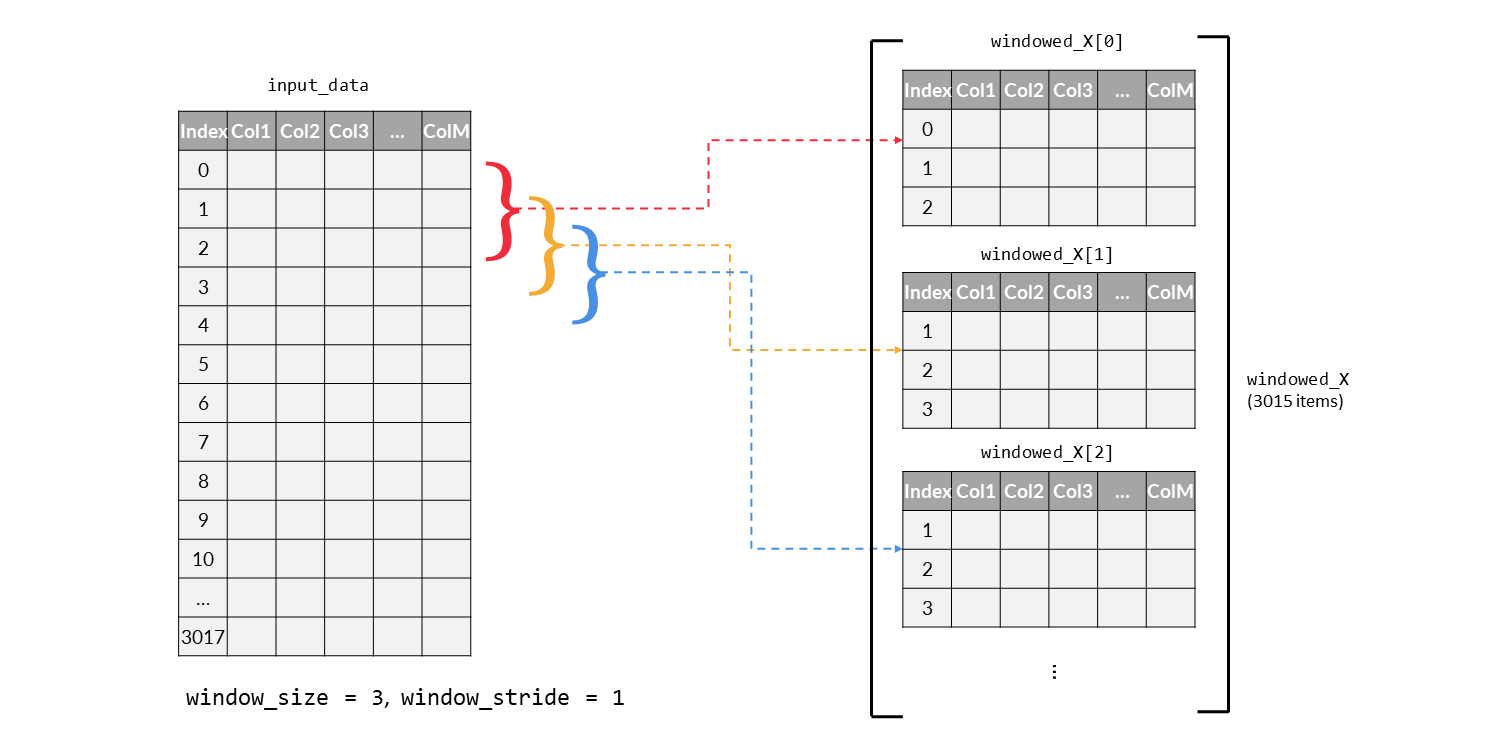

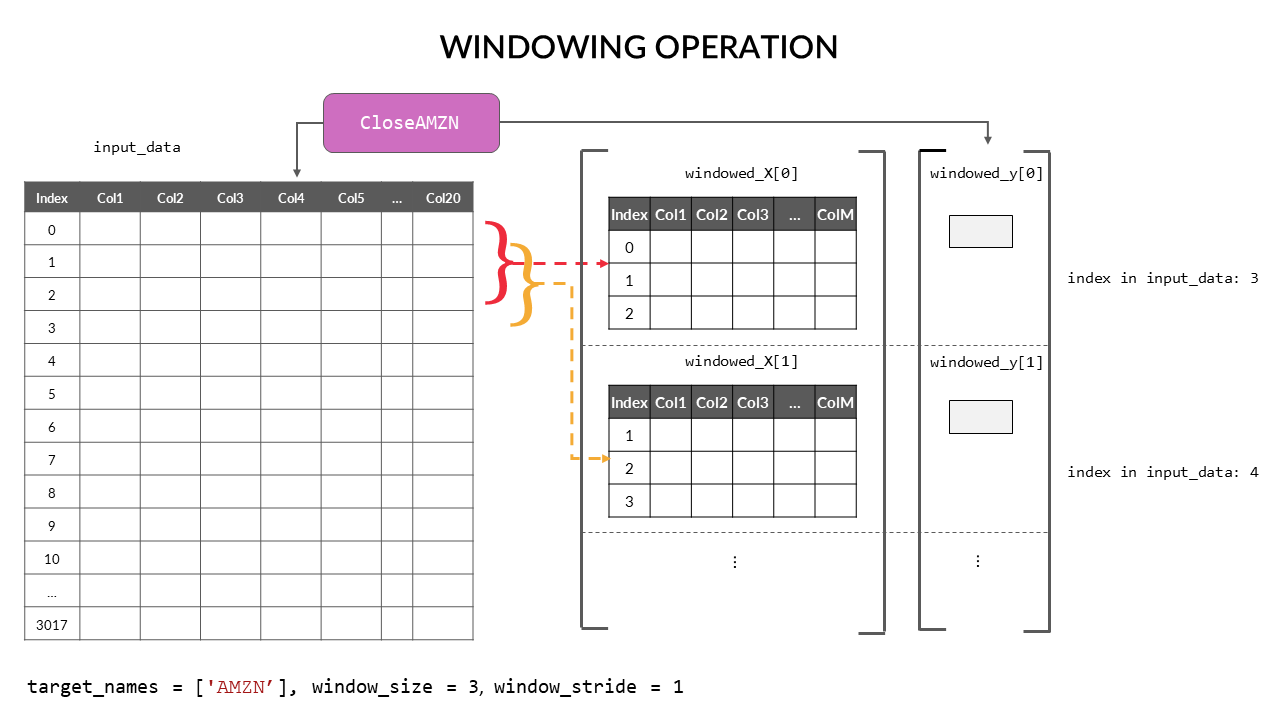

Let us define the main function that will call all of the helper functions: *create_data_instances()*.

The input parameters for this function are:
- The joined master data set
- The names of the stocks that we wish to predict the *Close* prices for
- The window size
- The window stride
- The train-test split ratio

The outputs from this function are:
- *X_train*
- *y_train*
- *X_test*
- *y_test*

In [11]:
# Define a function to create input and output data points from the master data frame
# Note: Controllable parameters here are 'target_names', 'window_size', 'window_stride' and 'test_split'
# Note: The 'target_names' parameter is a list of the names of the stocks whose 'Close' values we wish to predict
def create_data_instances(master_temp_data = None,
                          target_names = [],
                          window_size = 1,
                          window_stride = 1,
                          test_split = 0.1):
    
    # Create windows from the master data
    windowed_X, windowed_y = create_windows(input_data = master_temp_data,
                                            window_size = window_size,
                                            window_stride = window_stride,
                                            target_names = target_names)
    
    # Perform train-test split
    X_train_data, X_test_data, y_train_data, y_test_data = train_test_split(windowed_X,
                                                                            windowed_y,
                                                                            test_size = test_split,
                                                                            random_state = 123)
    
    # Scale the data sets
    X_train_data, X_test_data, y_train_data, y_test_data = scale_data(X_train_data, X_test_data, y_train_data, y_test_data)
    
    return X_train_data, y_train_data, X_test_data, y_test_data

Here is the function to execute the windowing operations:

In [12]:
# Define a function that divides the data into windows and generates target variable values for each window
# Note: Controllable parameters here are 'window_size', 'window_stride' and 'target_names'
# Note: The 'target_names' parameter is a list of the names of the stocks whose 'Close' values we wish to predict
def create_windows(input_data = None, window_size = 1, window_stride = 1, target_names = []):

    # Create lists for storing the windowed data
    new_X_data = []
    new_y_data = []

    # Iterate through the master input data set
    # Start from the first element of the master data set and stop at the first element of the last possible window
    # Use 'window_stride' as the step size in the loop
    for i in np.arange(0, len(input_data) - window_size, window_stride):
        
        # Extract and store the current X window
        data_point = input_data.iloc[(i):(i + window_size)]
        new_X_data.append(data_point)
        
        # Extract and store the y value(s) associated with the current X window
        y_val = input_data.iloc[i + window_size][['Close' + name for name in target_names]]
        new_y_data.append(y_val)
    
    new_y_data = pd.DataFrame(new_y_data)
    
    return new_X_data, new_y_data

Let's now define a function that will scale the data after the train-test split. We will use the *MinMaxScaler()* to scale the data. Note that to train the scaler, we use the *partial_fit()* method. This is because we want to train the scaler on all the windows contained in *X_train_data*. The *partial_fit()* method allows us to do that as it fits the data online.

In [13]:
# Define a function that scales the windowed data using a min-max scaler
# Note: each data frame is a window, and the input data is a list of data frames
# The function takes in the data sets and returns the scaled data sets
def scale_data(X_train_data, X_test_data, y_train_data, y_test_data):
    # Create a min-max scaler object
    scaler = MinMaxScaler()
    
    # Use the 'partial_fit' method to fit the scaler over all the windows iteratively
    for window in X_train_data:
        scaler.partial_fit(window)
    
    # Transform 'X_train_data' using the scaler
    X_train_data = [scaler.transform(window) for window in X_train_data]
    
    # Transform 'X_test_data' using the scaler
    X_test_data = [scaler.transform(window) for window in X_test_data]
    
    # Fit the scaler on 'y_train_data' and transform it
    y_train_data = scaler.fit_transform(y_train_data)
    
    # Transform 'y_test_data'
    y_test_data = scaler.transform(y_test_data)
    
    return X_train_data, X_test_data, y_train_data, y_test_data

Let's now use all of these helper functions to create our training and testing data sets.

In [14]:
# Create data instances from the master data frame using a window size of 75, a window stride of 5 and a test size of 20%
window_size = 75
window_stride = 5
test_split = 0.2
target_names = ['AMZN']

X_train, y_train, X_test, y_test = create_data_instances(master_temp_data = master_data,
                                                         window_size = window_size,
                                                         window_stride = window_stride,
                                                         test_split = test_split,
                                                         target_names = ['AMZN'])

Let's look at how many training and testing data points were generated.

In [15]:
# Check the number of data points generated
print('Number of training data points generated = {}'.format(len(y_train)))
print('Number of testing data points generated = {}'.format(len(y_test)))

Number of training data points generated = 471
Number of testing data points generated = 118


We need to convert the training and testing data into numpy arrays (which is required for training neural networks) as our helper functions return them as lists.

In [16]:
# Convert the training and testing data into numpy arrays
X_train = np.array(X_train)
y_train = np.array(y_train)
X_test = np.array(X_test)
y_test = np.array(y_test)

Let's now look at the shape of our data sets.

In [17]:
# Check the dimensions of the training and testing data
print('Shape of training data input = {}'.format(X_train.shape))
print('Shape of training data output = {}'.format(y_train.shape))
print('Shape of testing data input = {}'.format(X_test.shape))
print('Shape of testing data output = {}'.format(y_test.shape))

Shape of training data input = (471, 75, 20)
Shape of training data output = (471, 1)
Shape of testing data input = (118, 75, 20)
Shape of testing data output = (118, 1)


Note that the data are in the right shape for feeding into recurrent neural networks.

In [18]:
# Store input data shape for RNNs, LSTM networks and GRU networks
inputdims = (X_train.shape[1], X_train.shape[2])

In [19]:
# Store the output dimensionality for all the neural networks
n_outputs = len(target_names)

# Part 2 - Simple RNN Models
In this section, we will:
- Define a function that creates a simple RNN
- Tune the RNN for different hyperparameter values
- View the performance of the optimal model on the test data

## Subpart 1 - Simple RNN Function

In [20]:
# Define a function to create an RNN model and specify default values for hyperparameters
def create_rnn(cells_config = [1],
               activation_function_rnn = 'tanh'):
    
    # Declare an instance of a neural network model
    nn = Sequential()
    
    # Specify the input shape by adding an input layer
    nn.add(Input(shape = inputdims))
    
    # Interpret the number of recurrent layers
    n_rnn = len(cells_config)
    
    # Conditionally add recurrent layers to the network
    # Note: All non-ultimate recurrent layers have 'return_sequences' set to 'True'
    for i in np.arange(0, n_rnn - 1, 1):
        nn.add(SimpleRNN(units = cells_config[i],
                         return_sequences = True,
                         activation = activation_function_rnn))
    
    # Add the ultimate recurrent layer
    # Note: The ultimate recurrent layer has 'return_sequences' set to 'False'
    nn.add(SimpleRNN(units = cells_config[n_rnn - 1],
                     return_sequences = False,
                     activation = activation_function_rnn))
    
    # Add an output layer to the network
    # Note: Since this is a regression exercise, we use as many output neurons as the number of target output features
    # Note: We use a linear activation function since this is a regression exercise
    nn.add(Dense(units = n_outputs,
                 activation = 'linear'))
    
    # Compile the network
    # Note: Since this is a regression exercise, we use mean squared error as the loss function
    # Note: Performance can be measured using the RMSE
    nn.compile(loss = 'mean_squared_error',
               optimizer = RMSprop(learning_rate = 0.1))
    
    return(nn)

## Subpart 2 - Simple RNN Model: Hyperparameter Tuning

In [21]:
# Initialize a basic RNN object using the 'KerasRegressor()' method
base_grid_model = KerasRegressor(build_fn = create_rnn)

# Define ranges of hyperparameters and store it in a parameter grid dictionary
parameters_grid = {'cells_config': [[2], [4], [4, 2]],
                   'activation_function_rnn': ['tanh', 'relu']}

# Perform a grid search using the 'GridSearchCV()' method to obtain a grid on which to fit the training data
grid = GridSearchCV(estimator = base_grid_model,
                    param_grid = parameters_grid,
                    cv = 2,
                    verbose = 4)

# Fit the grid model to the training data
# Note: There is no need for validation split here as cross-validation is already in place
grid_model = grid.fit(X_train, y_train, epochs = 10)

Fitting 2 folds for each of 6 candidates, totalling 12 fits
Epoch 1/10
8/8 [==============================] - 1s 14ms/step - loss: 0.1505
Epoch 2/10
8/8 [==============================] - 0s 13ms/step - loss: 0.0154
Epoch 3/10
8/8 [==============================] - 0s 14ms/step - loss: 0.0289
Epoch 4/10
8/8 [==============================] - 0s 11ms/step - loss: 0.0287
Epoch 5/10
8/8 [==============================] - 0s 10ms/step - loss: 0.0051
Epoch 6/10
8/8 [==============================] - 0s 12ms/step - loss: 0.0428
Epoch 7/10
8/8 [==============================] - 0s 11ms/step - loss: 0.0192
Epoch 8/10
8/8 [==============================] - 0s 11ms/step - loss: 0.0164
Epoch 9/10
8/8 [==============================] - 0s 9ms/step - loss: 0.0452
Epoch 10/10
8/8 [==============================] - 0s 4ms/step - loss: 0.0104
[CV 1/2] END activation_function_rnn=tanh, cells_config=[2];, score=-0.010 total time=   2.7s
Epoch 1/10
8/8 [==============================] - 1s 11ms/step - lo

In [22]:
# View the optimal values of the hyperparameters
best_cells_config = grid_model.best_params_['cells_config']
best_activation_function_rnn = grid_model.best_params_['activation_function_rnn']
best_mse = grid_model.best_score_

print('The optimal configuration of RNN cells is', best_cells_config)
print('The optimal activation function for recurrent neurons is', best_activation_function_rnn)
print('The root mean squared error of the model with these optimal parameters is ', np.sqrt(abs(best_mse)))

The optimal configuration of RNN cells is [4]
The optimal activation function for recurrent neurons is relu
The root mean squared error of the model with these optimal parameters is  0.1411614236910676


Mean squared error (MSE), and its square root, root mean square error (RMSE), can be used to interpret the performance of a regression model. But as we have scaled the target variable, we can not readily interpret the MSE and the RMSE, though we can use them to compare the performance of different models.

## Subpart 3 - Optimal Simple RNN Model

In [23]:
# Create an RNN model with a combination of potentially optimal hyperparameter values and retrain the model
nn1 = create_rnn(cells_config = best_cells_config,
                 activation_function_rnn = best_activation_function_rnn)

nn1.summary()
print('\n')
nn1_history = nn1.fit(X_train, y_train, validation_split = 0.2, epochs = 10)

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_17 (SimpleRNN)   (None, 4)                 100       
                                                                 
 dense_13 (Dense)            (None, 1)                 5         
                                                                 
Total params: 105
Trainable params: 105
Non-trainable params: 0
_________________________________________________________________


Epoch 1/10
12/12 [==============================] - 2s 53ms/step - loss: 0.1000 - val_loss: 0.0611
Epoch 2/10
12/12 [==============================] - 0s 25ms/step - loss: 0.0576 - val_loss: 0.0613
Epoch 3/10
12/12 [==============================] - 0s 26ms/step - loss: 0.0612 - val_loss: 0.0619
Epoch 4/10
12/12 [==============================] - 0s 27ms/step - loss: 0.0571 - val_loss: 0.0646
Epoch 5/10
12/12 [==============================] - 0

In [24]:
# Convert the RNN history object into a data frame to view its specifics
hist = pd.DataFrame(nn1_history.history)
hist['epoch'] = nn1_history.epoch
hist['epoch'] = hist['epoch'].apply(lambda x: x + 1)
hist['rmse'] = hist['loss'].apply(np.sqrt)
hist['val_rmse'] = hist['val_loss'].apply(np.sqrt)
hist.set_index('epoch')

,loss,val_loss,rmse,val_rmse
epoch,,,,
1,0.100030,0.061149,0.316275,0.247284
2,0.057629,0.061340,0.240061,0.247669
3,0.061234,0.061926,0.247456,0.248850
4,0.057109,0.064595,0.238975,0.254156
5,0.059708,0.061774,0.244353,0.248545
6,0.059240,0.060497,0.243393,0.245961
7,0.060273,0.061148,0.245505,0.247281
8,0.062467,0.060650,0.249933,0.246272
9,0.064912,0.060480,0.254779,0.245927


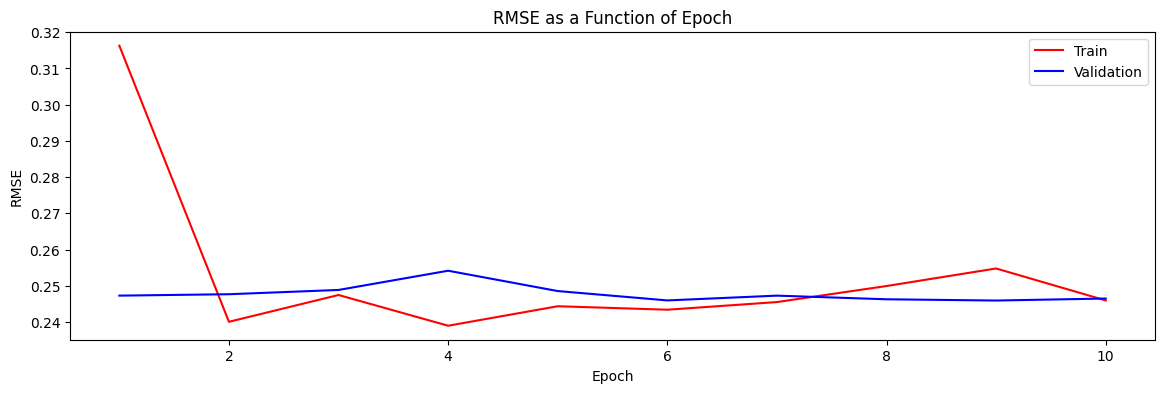

In [25]:
# View the training and validation RMSEs as functions of epoch
plt.figure(figsize = (14, 4))

sns.lineplot(data = hist, x = 'epoch', y = 'rmse', color = 'red', label = 'Train')
sns.lineplot(data = hist, x = 'epoch', y = 'val_rmse', color = 'blue', label = 'Validation')
plt.xlabel('Epoch')
plt.ylabel('RMSE')
plt.title('RMSE as a Function of Epoch');

It is worth noting that every training session for a neural network is unique. So, the results may vary slightly each time you retrain the model.

In [26]:
# Compute the performance of the model on the testing data set
performance_test = nn1.evaluate(X_test, y_test)

print('The loss value of the model on the test data is {}'.format(performance_test))
print('The RMSE of the model on the test data is {}'.format(np.sqrt(performance_test)))

4/4 [==============================] - 0s 9ms/step - loss: 0.0607
The loss value of the model on the test data is 0.060659751296043396
The RMSE of the model on the test data is 0.2462920041252728


# Part 3 - LSTM Network Models
In this section, we will:
- Define a function that creates an LSTM network
- Tune the network for different hyperparameter values
- View the performance of the optimal model on the test data

## Subpart 1 - LSTM Network Function

In [27]:
# Define a function to create an LSTM network model and specify default values for hyperparameters
def create_lstmn(units_config = [1]):
    
    # Declare an instance of a neural network model
    nn = Sequential()
    
    # Specify the input shape by adding an input layer
    nn.add(Input(shape = inputdims))
    
    # Interpret the number of LSTM layers
    n_lstm = len(units_config)
    
    # Conditionally add LSTM layers to the network
    # Note: All non-ultimate LSTM layers have 'return_sequences' set to 'True'
    for i in np.arange(0, n_lstm - 1, 1):
        nn.add(LSTM(units = units_config[i],
                    return_sequences = True))
    
    # Add the ultimate LSTM layer
    # Note: The ultimate LSTM layer has 'return_sequences' set to 'False'
    nn.add(LSTM(units = units_config[n_lstm - 1],
                return_sequences = False))
    
    # Add an output layer to the network
    # Note: Since this is a regression exercise, we use as many output neurons as the number of target output features
    # Note: We use a linear activation function since this is a regression exercise
    nn.add(Dense(units = n_outputs,
                 activation = 'linear'))
    
    # Compile the network
    # Note: Since this is a regression exercise, we use mean squared error as the loss function
    # Note: Performance can be measured using the RMSE
    nn.compile(loss = 'mean_squared_error',
               optimizer = RMSprop(learning_rate = 0.1))
    
    return(nn)

## Subpart 2 - LSTM Network Models

In [28]:
# Initialize a basic LSTM network object using the 'KerasRegressor()' method
base_grid_model = KerasRegressor(build_fn = create_lstmn)

# Define ranges of hyperparameters and store it in a parameter grid dictionary
parameters_grid = {'units_config': [[2], [4], [4, 2]]}

# Perform a grid search using the 'GridSearchCV()' method to obtain a grid on which to fit the training data
grid = GridSearchCV(estimator = base_grid_model,
                    param_grid = parameters_grid,
                    cv = 2,
                    verbose = 4)

# Fit the grid model to the training data
# Note: There is no need for validation split here as cross-validation is already in place
grid_model = grid.fit(X_train, y_train, epochs = 10)

Fitting 2 folds for each of 3 candidates, totalling 6 fits
Epoch 1/10
8/8 [==============================] - 4s 43ms/step - loss: 0.1466
Epoch 2/10
8/8 [==============================] - 0s 40ms/step - loss: 0.0079
Epoch 3/10
8/8 [==============================] - 0s 37ms/step - loss: 0.0266
Epoch 4/10
8/8 [==============================] - 0s 38ms/step - loss: 0.0113
Epoch 5/10
8/8 [==============================] - 0s 40ms/step - loss: 0.0280
Epoch 6/10
8/8 [==============================] - 0s 41ms/step - loss: 0.0126
Epoch 7/10
8/8 [==============================] - 0s 42ms/step - loss: 0.0105
Epoch 8/10
8/8 [==============================] - 0s 39ms/step - loss: 0.0138
Epoch 9/10
8/8 [==============================] - 0s 38ms/step - loss: 0.0127
Epoch 10/10
8/8 [==============================] - 1s 8ms/step - loss: 0.0221
[CV 1/2] END .................units_config=[2];, score=-0.022 total time=   7.8s
Epoch 1/10
8/8 [==============================] - 2s 21ms/step - loss: 0.0903
Ep

In [29]:
# View the optimal values of the hyperparameters
best_units_config = grid_model.best_params_['units_config']
best_mse = grid_model.best_score_

print('The optimal configuration of LSTM units is', best_units_config)
print('The root mean squared error of the model with these optimal parameters is ', np.sqrt(abs(best_mse)))

The optimal configuration of LSTM units is [4]
The root mean squared error of the model with these optimal parameters is  0.05122155487908777


Note that the activation functions in gated cells such as LSTM units and GRUs are highly specialized. In general, we do not need to tune for them.

## Subpart 3 - Optimal LSTM Network Model

In [30]:
# Create an LSTM network model with a combination of potentially optimal hyperparameter values and retrain the model
nn2 = create_lstmn(units_config = best_units_config)

nn2.summary()
print('\n')
nn2_history = nn2.fit(X_train, y_train, validation_split = 0.2, epochs = 10)

Model: "sequential_21"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_9 (LSTM)               (None, 4)                 400       
                                                                 
 dense_21 (Dense)            (None, 1)                 5         
                                                                 
Total params: 405
Trainable params: 405
Non-trainable params: 0
_________________________________________________________________


Epoch 1/10
12/12 [==============================] - 3s 77ms/step - loss: 0.1384 - val_loss: 0.0558
Epoch 2/10
12/12 [==============================] - 0s 34ms/step - loss: 0.0306 - val_loss: 0.0630
Epoch 3/10
12/12 [==============================] - 0s 29ms/step - loss: 0.0242 - val_loss: 0.0243
Epoch 4/10
12/12 [==============================] - 0s 29ms/step - loss: 0.0232 - val_loss: 0.0167
Epoch 5/10
12/12 [==============================] - 0

In [31]:
# Convert the LSTM network history object into a data frame to view its specifics
hist = pd.DataFrame(nn2_history.history)
hist['epoch'] = nn2_history.epoch
hist['epoch'] = hist['epoch'].apply(lambda x: x + 1)
hist['rmse'] = hist['loss'].apply(np.sqrt)
hist['val_rmse'] = hist['val_loss'].apply(np.sqrt)
hist.set_index('epoch')

,loss,val_loss,rmse,val_rmse
epoch,,,,
1,0.138416,0.055806,0.372044,0.236233
2,0.030569,0.063015,0.174840,0.251028
3,0.024215,0.024325,0.155613,0.155966
4,0.023207,0.016698,0.152340,0.129222
5,0.025182,0.005752,0.158688,0.075841
6,0.017360,0.019269,0.131759,0.138811
7,0.012693,0.023337,0.112665,0.152764
8,0.010156,0.012923,0.100776,0.113680
9,0.011007,0.028728,0.104913,0.169492


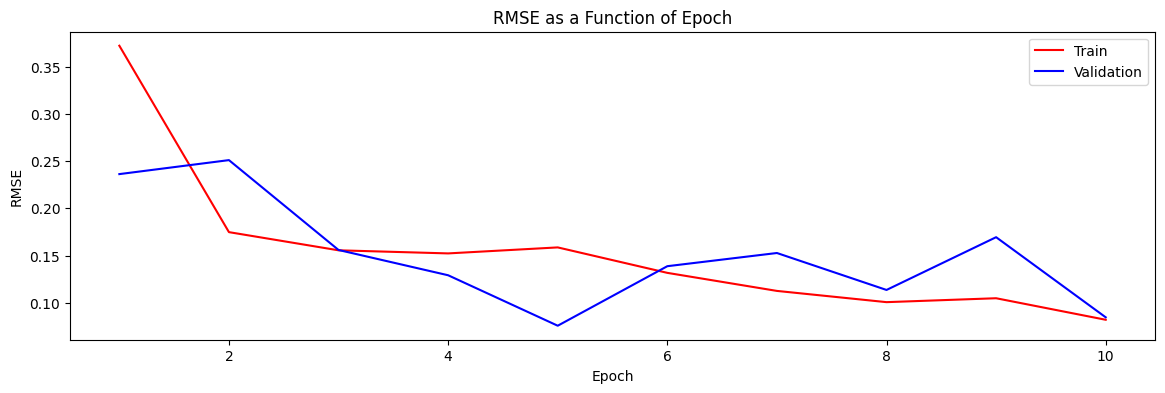

In [32]:
# View the training and validation RMSEs as functions of epoch
plt.figure(figsize = (14, 4))

sns.lineplot(data = hist, x = 'epoch', y = 'rmse', color = 'red', label = 'Train')
sns.lineplot(data = hist, x = 'epoch', y = 'val_rmse', color = 'blue', label = 'Validation')
plt.xlabel('Epoch')
plt.ylabel('RMSE')
plt.title('RMSE as a Function of Epoch');

It is worth noting that every training session for a neural network is unique. So, the results may vary slightly each time you retrain the model.

In [33]:
# Compute the performance of the model on the testing data set
performance_test = nn2.evaluate(X_test, y_test)

print('The loss value of the model on the test data is {}'.format(performance_test))
print('The RMSE of the model on the test data is {}'.format(np.sqrt(performance_test)))

4/4 [==============================] - 0s 7ms/step - loss: 0.0068
The loss value of the model on the test data is 0.006816577166318893
The RMSE of the model on the test data is 0.08256256516314699


# Part 4 - GRU Network Models
In this section, we will:
- Define a function that creates a GRU network
- Tune the GRU network for different hyperparameter values
- View the performance of the optimal model on the test data

## Subpart 1 - GRU Network Function

In [34]:
# Define a function to create a GRU network model and specify default values for hyperparameters
def create_grun(units_config = [1]):
    
    # Declare an instance of a neural network model
    nn = Sequential()
    
    # Specify the input shape by adding an input layer
    nn.add(Input(shape = inputdims))
    
    # Interpret the number of GRU layers
    n_gru = len(units_config)
    
    # Conditionally add GRU layers to the network
    # Note: All non-ultimate GRU layers have 'return_sequences' set to 'True'
    for i in np.arange(0, n_gru - 1, 1):
        nn.add(GRU(units = units_config[i],
                   return_sequences = True))
    
    # Add the ultimate GRU layer
    # Note: The ultimate GRU layer has 'return_sequences' set to 'False'
    nn.add(GRU(units = units_config[n_gru - 1],
               return_sequences = False))
    
    # Add an output layer to the network
    # Note: Since this is a regression exercise, we use as many output neurons as the number of target output features
    # Note: We use a linear activation function since this is a regression exercise
    nn.add(Dense(units = n_outputs,
                 activation = 'linear'))
    
    # Compile the network
    # Note: Since this is a regression exercise, we use mean squared error as the loss function
    # Note: Performance can be measured using the RMSE
    nn.compile(loss = 'mean_squared_error',
               optimizer = RMSprop(learning_rate = 0.1))
    
    return(nn)

## Subpart 2 - GRU Network Models

In [35]:
# Initialize a basic GRU network object using the 'KerasRegressor()' method
base_grid_model = KerasRegressor(build_fn = create_grun)

# Define ranges of hyperparameters and store it in a parameter grid dictionary
parameters_grid = {'units_config': [[2], [4], [4, 2]]}

# Perform a grid search using the 'GridSearchCV()' method to obtain a grid on which to fit the training data
grid = GridSearchCV(estimator = base_grid_model,
                    param_grid = parameters_grid,
                    cv = 2,
                    verbose = 4)

# Fit the grid model to the training data
# Note: There is no need for validation split here as cross-validation is already in place
grid_model = grid.fit(X_train, y_train, epochs = 10)

Fitting 2 folds for each of 3 candidates, totalling 6 fits
Epoch 1/10
8/8 [==============================] - 2s 22ms/step - loss: 0.1081
Epoch 2/10
8/8 [==============================] - 0s 30ms/step - loss: 0.0249
Epoch 3/10
8/8 [==============================] - 0s 31ms/step - loss: 0.0325
Epoch 4/10
8/8 [==============================] - 0s 31ms/step - loss: 0.0362
Epoch 5/10
8/8 [==============================] - 0s 30ms/step - loss: 0.0204
Epoch 6/10
8/8 [==============================] - 0s 29ms/step - loss: 0.0301
Epoch 7/10
8/8 [==============================] - 0s 27ms/step - loss: 0.0356
Epoch 8/10
8/8 [==============================] - 0s 28ms/step - loss: 0.0183
Epoch 9/10
8/8 [==============================] - 0s 27ms/step - loss: 0.0303
Epoch 10/10
8/8 [==============================] - 0s 5ms/step - loss: 0.0129
[CV 1/2] END .................units_config=[2];, score=-0.013 total time=   5.3s
Epoch 1/10
8/8 [==============================] - 2s 23ms/step - loss: 0.7654
Ep

In [36]:
# View the optimal values of the hyperparameters
best_units_config = grid_model.best_params_['units_config']
best_mse = grid_model.best_score_

print('The optimal configuration of GRUs is', best_units_config)
print('The root mean squared error of the model with these optimal parameters is ', np.sqrt(abs(best_mse)))

The optimal configuration of GRUs is [2]
The root mean squared error of the model with these optimal parameters is  0.16396374511805087


Note that the activation functions in gated cells such as LSTM units and GRUs are highly specialized. In general, we do not need to tune for them.

## Subpart 3 - Optimal GRU Network Model

In [37]:
# Create a GRU network model with a combination of potentially optimal hyperparameter values and retrain the model
nn3 = create_grun(units_config = best_units_config)

nn3.summary()
print('\n')
nn3_history = nn3.fit(X_train, y_train, validation_split = 0.2, epochs = 10)

Model: "sequential_29"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_9 (GRU)                 (None, 2)                 144       
                                                                 
 dense_29 (Dense)            (None, 1)                 3         
                                                                 
Total params: 147
Trainable params: 147
Non-trainable params: 0
_________________________________________________________________


Epoch 1/10
12/12 [==============================] - 3s 70ms/step - loss: 0.0980 - val_loss: 0.0416
Epoch 2/10
12/12 [==============================] - 0s 34ms/step - loss: 0.0402 - val_loss: 0.0258
Epoch 3/10
12/12 [==============================] - 0s 31ms/step - loss: 0.0346 - val_loss: 0.0116
Epoch 4/10
12/12 [==============================] - 0s 34ms/step - loss: 0.0189 - val_loss: 0.0160
Epoch 5/10
12/12 [==============================] - 0

In [38]:
# Convert the GRU network history object into a data frame to view its specifics
hist = pd.DataFrame(nn3_history.history)
hist['epoch'] = nn3_history.epoch
hist['epoch'] = hist['epoch'].apply(lambda x: x + 1)
hist['rmse'] = hist['loss'].apply(np.sqrt)
hist['val_rmse'] = hist['val_loss'].apply(np.sqrt)
hist.set_index('epoch')

,loss,val_loss,rmse,val_rmse
epoch,,,,
1,0.098046,0.041625,0.313123,0.204022
2,0.040167,0.025815,0.200417,0.160669
3,0.034627,0.011587,0.186083,0.107644
4,0.018904,0.015985,0.137492,0.126432
5,0.013345,0.006308,0.115519,0.079425
6,0.027002,0.009197,0.164321,0.095902
7,0.009094,0.016271,0.095361,0.127559
8,0.020069,0.054531,0.141665,0.233518
9,0.012923,0.015142,0.113681,0.123054


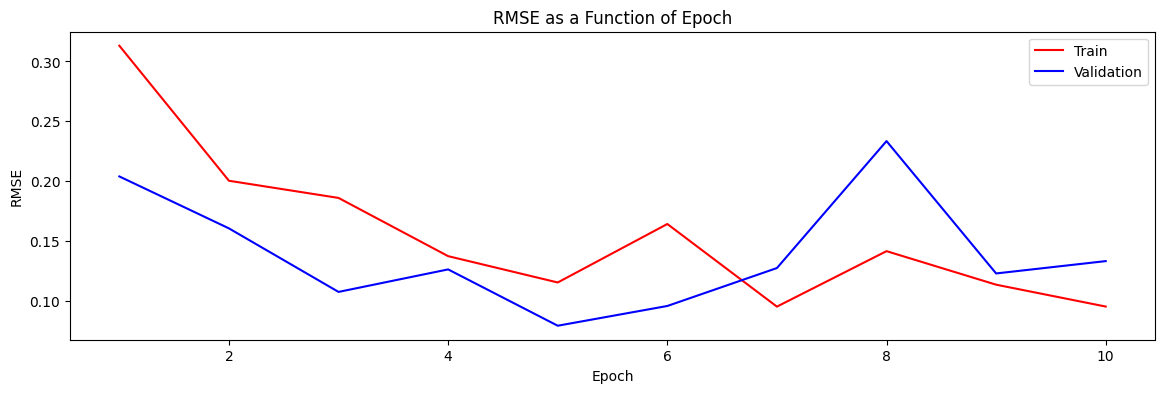

In [39]:
# View the training and validation RMSEs as functions of epoch
plt.figure(figsize = (14, 4))

sns.lineplot(data = hist, x = 'epoch', y = 'rmse', color = 'red', label = 'Train')
sns.lineplot(data = hist, x = 'epoch', y = 'val_rmse', color = 'blue', label = 'Validation')
plt.xlabel('Epoch')
plt.ylabel('RMSE')
plt.title('RMSE as a Function of Epoch');

It is worth noting that every training session for a neural network is unique. So, the results may vary slightly each time you retrain the model.

In [40]:
# Compute the performance of the model on the testing data set
performance_test = nn3.evaluate(X_test, y_test)

print('The loss value of the model on the test data is {}'.format(performance_test))
print('The RMSE of the model on the test data is {}'.format(np.sqrt(performance_test)))

4/4 [==============================] - 0s 7ms/step - loss: 0.0197
The loss value of the model on the test data is 0.019699089229106903
The RMSE of the model on the test data is 0.14035344395171392


# Part 5 - Predicting Multiple Target Variables

In this section, we will use recurrent neural networks to predict stock prices for more than one company.

## Subpart 1 -  Data Preparation

In [41]:
# Create data instances from the master data frame using a window size of 75, a window stride of 5 and a test size of 20%
# Note: Specify the list of stock names whose 'Close' values you wish to predict using the 'target_names' parameter
window_size = 75
window_stride = 5
test_split = 0.2
target_names = ['AMZN', 'GOOGL', 'IBM', 'MSFT']

X_train, y_train, X_test, y_test = create_data_instances(master_temp_data = master_data,
                                                         window_size = window_size,
                                                         window_stride = window_stride,
                                                         test_split = test_split,
                                                         target_names = ['AMZN', 'GOOGL', 'IBM', 'MSFT'])

In [42]:
# Check the number of data points generated
print('Number of training data points generated = {}'.format(len(y_train)))
print('Number of testing data points generated = {}'.format(len(y_test)))

Number of training data points generated = 471
Number of testing data points generated = 118


In [43]:
# Convert the training and testing data into numpy arrays
X_train = np.array(X_train)
y_train = np.array(y_train)
X_test = np.array(X_test)
y_test = np.array(y_test)

In [44]:
# Check the dimensions of the training and testing data
print('Shape of training data input = {}'.format(X_train.shape))
print('Shape of training data output = {}'.format(y_train.shape))
print('Shape of testing data input = {}'.format(X_test.shape))
print('Shape of testing data output = {}'.format(y_test.shape))

Shape of training data input = (471, 75, 20)
Shape of training data output = (471, 4)
Shape of testing data input = (118, 75, 20)
Shape of testing data output = (118, 4)


In [45]:
# Store the output dimensionality for all the networks
n_outputs = len(target_names)

## Subpart 2 -  Simple RNN Models

In [46]:
# Initialize a basic RNN object using the 'KerasRegressor()' method
base_grid_model = KerasRegressor(build_fn = create_rnn)

# Define ranges of hyperparameters and store it in a parameter grid dictionary
parameters_grid = {'cells_config': [[2], [4], [4, 2]],
                   'activation_function_rnn': ['tanh', 'relu']}

# Perform a grid search using the 'GridSearchCV()' method to obtain a grid on which to fit the training data
grid = GridSearchCV(estimator = base_grid_model,
                    param_grid = parameters_grid,
                    cv = 2,
                    verbose = 4)

# Fit the grid model to the training data
# Note: There is no need for validation split here as cross-validation is already in place
grid_model = grid.fit(X_train, y_train, epochs = 10)

Fitting 2 folds for each of 6 candidates, totalling 12 fits
Epoch 1/10
8/8 [==============================] - 1s 10ms/step - loss: 0.2409
Epoch 2/10
8/8 [==============================] - 0s 11ms/step - loss: 0.0435
Epoch 3/10
8/8 [==============================] - 0s 10ms/step - loss: 0.0400
Epoch 4/10
8/8 [==============================] - 0s 11ms/step - loss: 0.0176
Epoch 5/10
8/8 [==============================] - 0s 13ms/step - loss: 0.0387
Epoch 6/10
8/8 [==============================] - 0s 12ms/step - loss: 0.0190
Epoch 7/10
8/8 [==============================] - 0s 12ms/step - loss: 0.0293
Epoch 8/10
8/8 [==============================] - 0s 13ms/step - loss: 0.0208
Epoch 9/10
8/8 [==============================] - 0s 13ms/step - loss: 0.0167
Epoch 10/10
8/8 [==============================] - 0s 5ms/step - loss: 0.0358
[CV 1/2] END activation_function_rnn=tanh, cells_config=[2];, score=-0.036 total time=   2.2s
Epoch 1/10
8/8 [==============================] - 1s 9ms/step - lo

In [47]:
# View the optimal values of the hyperparameters
best_cells_config = grid_model.best_params_['cells_config']
best_activation_function_rnn = grid_model.best_params_['activation_function_rnn']
best_mse = grid_model.best_score_

print('The optimal configuration of RNN cells is', best_cells_config)
print('The optimal activation function for recurrent neurons is', best_activation_function_rnn)
print('The root mean squared error of the model with these optimal parameters is ', np.sqrt(abs(best_mse)))

The optimal configuration of RNN cells is [2]
The optimal activation function for recurrent neurons is tanh
The root mean squared error of the model with these optimal parameters is  0.14449628361879782


In [48]:
# Create an RNN model with a combination of potentially optimal hyperparameter values and retrain the model
nn4 = create_rnn(cells_config = best_cells_config,
                 activation_function_rnn = best_activation_function_rnn)

nn4.summary()
print('\n')
nn4_history = nn4.fit(X_train, y_train, validation_split = 0.2, epochs = 10)

Model: "sequential_43"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_35 (SimpleRNN)   (None, 2)                 46        
                                                                 
 dense_43 (Dense)            (None, 4)                 12        
                                                                 
Total params: 58
Trainable params: 58
Non-trainable params: 0
_________________________________________________________________


Epoch 1/10
12/12 [==============================] - 1s 31ms/step - loss: 0.1834 - val_loss: 0.0527
Epoch 2/10
12/12 [==============================] - 0s 13ms/step - loss: 0.0583 - val_loss: 0.0755
Epoch 3/10
12/12 [==============================] - 0s 13ms/step - loss: 0.0596 - val_loss: 0.0472
Epoch 4/10
12/12 [==============================] - 0s 18ms/step - loss: 0.0466 - val_loss: 0.0878
Epoch 5/10
12/12 [==============================] - 0s 

In [49]:
# Convert the RNN history object into a data frame to view its specifics
hist = pd.DataFrame(nn4_history.history)
hist['epoch'] = nn4_history.epoch
hist['epoch'] = hist['epoch'].apply(lambda x: x + 1)
hist['rmse'] = hist['loss'].apply(np.sqrt)
hist['val_rmse'] = hist['val_loss'].apply(np.sqrt)
hist.set_index('epoch')

,loss,val_loss,rmse,val_rmse
epoch,,,,
1,0.183361,0.052728,0.428206,0.229626
2,0.058253,0.075493,0.241357,0.274760
3,0.059562,0.047213,0.244054,0.217286
4,0.046626,0.087785,0.215930,0.296286
5,0.063115,0.030865,0.251227,0.175684
6,0.056657,0.035420,0.238028,0.188203
7,0.049658,0.026046,0.222841,0.161388
8,0.050242,0.051200,0.224148,0.226275
9,0.049785,0.035938,0.223126,0.189572


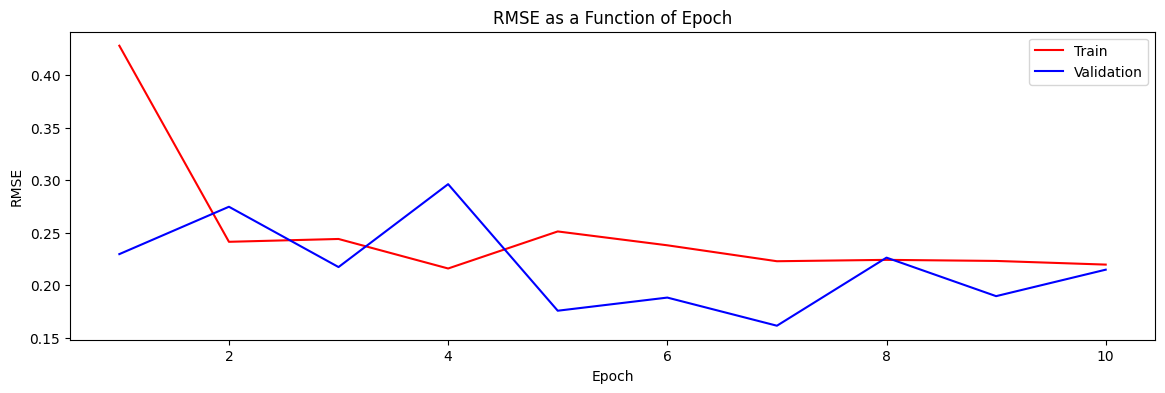

In [50]:
# View the training and validation RMSEs as functions of epoch
plt.figure(figsize = (14, 4))

sns.lineplot(data = hist, x = 'epoch', y = 'rmse', color = 'red', label = 'Train')
sns.lineplot(data = hist, x = 'epoch', y = 'val_rmse', color = 'blue', label = 'Validation')
plt.xlabel('Epoch')
plt.ylabel('RMSE')
plt.title('RMSE as a Function of Epoch');

It is worth noting that every training session for a neural network is unique. So, the results may vary slightly each time you retrain the model.

In [51]:
# Compute the performance of the model on the testing data set
performance_test = nn4.evaluate(X_test, y_test)

print('The loss value of the model on the test data is {}'.format(performance_test))
print('The RMSE of the model on the test data is {}'.format(np.sqrt(performance_test)))

4/4 [==============================] - 0s 5ms/step - loss: 0.0452
The loss value of the model on the test data is 0.04521183669567108
The RMSE of the model on the test data is 0.21263075199902548


## Subpart 3 - LSTM Network Models

In [52]:
# Initialize a basic LSTM network object using the 'KerasRegressor()' method
base_grid_model = KerasRegressor(build_fn = create_lstmn)

# Define ranges of hyperparameters and store it in a parameter grid dictionary
parameters_grid = {'units_config': [[2], [4], [4, 2]]}

# Perform a grid search using the 'GridSearchCV()' method to obtain a grid on which to fit the training data
grid = GridSearchCV(estimator = base_grid_model,
                    param_grid = parameters_grid,
                    cv = 2,
                    verbose = 4)

# Fit the grid model to the training data
# Note: There is no need for validation split here as cross-validation is already in place
grid_model = grid.fit(X_train, y_train, epochs = 10)

Fitting 2 folds for each of 3 candidates, totalling 6 fits
Epoch 1/10
8/8 [==============================] - 2s 21ms/step - loss: 0.0956
Epoch 2/10
8/8 [==============================] - 0s 28ms/step - loss: 0.0287
Epoch 3/10
8/8 [==============================] - 0s 26ms/step - loss: 0.0373
Epoch 4/10
8/8 [==============================] - 0s 28ms/step - loss: 0.0289
Epoch 5/10
8/8 [==============================] - 0s 28ms/step - loss: 0.0226
Epoch 6/10
8/8 [==============================] - 0s 25ms/step - loss: 0.0344
Epoch 7/10
8/8 [==============================] - 0s 25ms/step - loss: 0.0169
Epoch 8/10
8/8 [==============================] - 0s 26ms/step - loss: 0.0272
Epoch 9/10
8/8 [==============================] - 0s 33ms/step - loss: 0.0287
Epoch 10/10
8/8 [==============================] - 1s 6ms/step - loss: 0.0242
[CV 1/2] END .................units_config=[2];, score=-0.024 total time=   5.2s
Epoch 1/10
8/8 [==============================] - 2s 21ms/step - loss: 0.0777
Ep

In [53]:
# View the optimal values of the hyperparameters
best_units_config = grid_model.best_params_['units_config']
best_mse = grid_model.best_score_

print('The optimal configuration of LSTM units is', best_units_config)
print('The root mean squared error of the model with these optimal parameters is ', np.sqrt(abs(best_mse)))

The optimal configuration of LSTM units is [4, 2]
The root mean squared error of the model with these optimal parameters is  0.09734230360744507


In [54]:
# Create an LSTM network model with a combination of potentially optimal hyperparameter values and retrain the model
nn5 = create_lstmn(units_config = best_units_config)

nn5.summary()
print('\n')
nn5_history = nn5.fit(X_train, y_train, validation_split = 0.2, epochs = 10)

Model: "sequential_51"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_20 (LSTM)              (None, 75, 4)             400       
                                                                 
 lstm_21 (LSTM)              (None, 2)                 56        
                                                                 
 dense_51 (Dense)            (None, 4)                 12        
                                                                 
Total params: 468
Trainable params: 468
Non-trainable params: 0
_________________________________________________________________


Epoch 1/10
12/12 [==============================] - 5s 138ms/step - loss: 0.0901 - val_loss: 0.0608
Epoch 2/10
12/12 [==============================] - 1s 54ms/step - loss: 0.0580 - val_loss: 0.0515
Epoch 3/10
12/12 [==============================] - 1s 51ms/step - loss: 0.0528 - val_loss: 0.0278
Epoch 4/10
12/12 [=

In [55]:
# Convert the LSTM network history object into a data frame to view its specifics
hist = pd.DataFrame(nn5_history.history)
hist['epoch'] = nn5_history.epoch
hist['epoch'] = hist['epoch'].apply(lambda x: x + 1)
hist['rmse'] = hist['loss'].apply(np.sqrt)
hist['val_rmse'] = hist['val_loss'].apply(np.sqrt)
hist.set_index('epoch')

,loss,val_loss,rmse,val_rmse
epoch,,,,
1,0.090126,0.060818,0.300209,0.246612
2,0.058001,0.051494,0.240833,0.226924
3,0.052821,0.027773,0.229829,0.166653
4,0.030650,0.020218,0.175071,0.142189
5,0.024610,0.015962,0.156877,0.126339
6,0.017827,0.018734,0.133519,0.136874
7,0.014399,0.011602,0.119997,0.107713
8,0.014066,0.010821,0.118599,0.104022
9,0.019470,0.007921,0.139533,0.088998


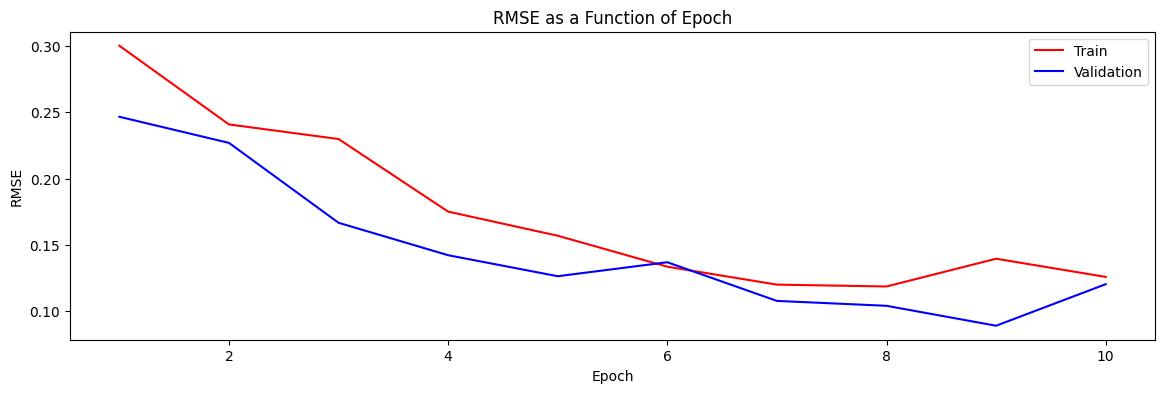

In [56]:
# View the training and validation RMSEs as functions of epoch
plt.figure(figsize = (14, 4))

sns.lineplot(data = hist, x = 'epoch', y = 'rmse', color = 'red', label = 'Train')
sns.lineplot(data = hist, x = 'epoch', y = 'val_rmse', color = 'blue', label = 'Validation')
plt.xlabel('Epoch')
plt.ylabel('RMSE')
plt.title('RMSE as a Function of Epoch');

It is worth noting that every training session for a neural network is unique. So, the results may vary slightly each time you retrain the model.

In [57]:
# Compute the performance of the model on the testing data set
performance_test = nn5.evaluate(X_test, y_test)

print('The loss value of the model on the test data is {}'.format(performance_test))
print('The RMSE of the model on the test data is {}'.format(np.sqrt(performance_test)))

4/4 [==============================] - 0s 13ms/step - loss: 0.0166
The loss value of the model on the test data is 0.01655416004359722
The RMSE of the model on the test data is 0.1286629707553701


## Subpart 4 - GRU Network Models

In [58]:
# Initialize a basic GRU network object using the 'KerasRegressor()' method
base_grid_model = KerasRegressor(build_fn = create_grun)

# Define ranges of hyperparameters and store it in a parameter grid dictionary
parameters_grid = {'units_config': [[2], [4], [4, 2]]}

# Perform a grid search using the 'GridSearchCV()' method to obtain a grid on which to fit the training data
grid = GridSearchCV(estimator = base_grid_model,
                    param_grid = parameters_grid,
                    cv = 2,
                    verbose = 4)

# Fit the grid model to the training data
# Note: There is no need for validation split here as cross-validation is already in place
grid_model = grid.fit(X_train, y_train, epochs = 10)

Fitting 2 folds for each of 3 candidates, totalling 6 fits
Epoch 1/10
8/8 [==============================] - 2s 27ms/step - loss: 0.1691
Epoch 2/10
8/8 [==============================] - 0s 27ms/step - loss: 0.0542
Epoch 3/10
8/8 [==============================] - 0s 26ms/step - loss: 0.0477
Epoch 4/10
8/8 [==============================] - 0s 26ms/step - loss: 0.0289
Epoch 5/10
8/8 [==============================] - 0s 26ms/step - loss: 0.0413
Epoch 6/10
8/8 [==============================] - 0s 27ms/step - loss: 0.0200
Epoch 7/10
8/8 [==============================] - 0s 27ms/step - loss: 0.0219
Epoch 8/10
8/8 [==============================] - 0s 28ms/step - loss: 0.0524
Epoch 9/10
8/8 [==============================] - 0s 28ms/step - loss: 0.0091
Epoch 10/10
8/8 [==============================] - 0s 5ms/step - loss: 0.0095
[CV 1/2] END .................units_config=[2];, score=-0.010 total time=   4.8s
Epoch 1/10
8/8 [==============================] - 2s 23ms/step - loss: 0.3409
Ep

In [59]:
# View the optimal values of the hyperparameters
best_units_config = grid_model.best_params_['units_config']
best_mse = grid_model.best_score_

print('The optimal configuration of GRUs is', best_units_config)
print('The root mean squared error of the model with these optimal parameters is ', np.sqrt(abs(best_mse)))

The optimal configuration of GRUs is [2]
The root mean squared error of the model with these optimal parameters is  0.09257740088875785


In [60]:
# Create a GRU network model with a combination of potentially optimal hyperparameter values and retrain the model
nn6 = create_grun(units_config = best_units_config)

nn6.summary()
print('\n')
nn6_history = nn6.fit(X_train, y_train, validation_split = 0.2, epochs = 10)

Model: "sequential_59"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_19 (GRU)                (None, 2)                 144       
                                                                 
 dense_59 (Dense)            (None, 4)                 12        
                                                                 
Total params: 156
Trainable params: 156
Non-trainable params: 0
_________________________________________________________________


Epoch 1/10
12/12 [==============================] - 4s 110ms/step - loss: 0.2111 - val_loss: 0.0292
Epoch 2/10
12/12 [==============================] - 1s 45ms/step - loss: 0.0250 - val_loss: 0.0201
Epoch 3/10
12/12 [==============================] - 0s 39ms/step - loss: 0.0240 - val_loss: 0.0117
Epoch 4/10
12/12 [==============================] - 0s 36ms/step - loss: 0.0271 - val_loss: 0.0146
Epoch 5/10
12/12 [==============================] - 

In [61]:
# Convert the GRU network history object into a data frame to view its specifics
hist = pd.DataFrame(nn6_history.history)
hist['epoch'] = nn6_history.epoch
hist['epoch'] = hist['epoch'].apply(lambda x: x + 1)
hist['rmse'] = hist['loss'].apply(np.sqrt)
hist['val_rmse'] = hist['val_loss'].apply(np.sqrt)
hist.set_index('epoch')

,loss,val_loss,rmse,val_rmse
epoch,,,,
1,0.211061,0.029174,0.459414,0.170804
2,0.025049,0.020136,0.158269,0.141901
3,0.023981,0.011742,0.154860,0.108362
4,0.027133,0.014589,0.164721,0.120786
5,0.012641,0.058436,0.112432,0.241735
6,0.016013,0.019343,0.126541,0.139080
7,0.014722,0.029608,0.121336,0.172069
8,0.014302,0.008354,0.119590,0.091400
9,0.021426,0.005010,0.146378,0.070784


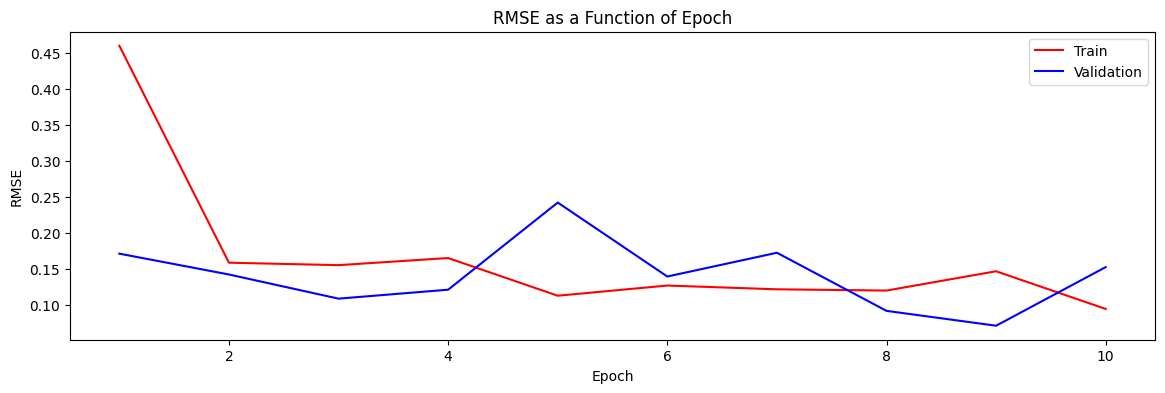

In [62]:
# View the training and validation RMSEs as functions of epoch
plt.figure(figsize = (14, 4))

sns.lineplot(data = hist, x = 'epoch', y = 'rmse', color = 'red', label = 'Train')
sns.lineplot(data = hist, x = 'epoch', y = 'val_rmse', color = 'blue', label = 'Validation')
plt.xlabel('Epoch')
plt.ylabel('RMSE')
plt.title('RMSE as a Function of Epoch');

It is worth noting that every training session for a neural network is unique. So, the results may vary slightly each time you retrain the model.

In [63]:
# Compute the performance of the model on the testing data set
performance_test = nn6.evaluate(X_test, y_test)

print('The loss value of the model on the test data is {}'.format(performance_test))
print('The RMSE of the model on the test data is {}'.format(np.sqrt(performance_test)))

4/4 [==============================] - 0s 9ms/step - loss: 0.0223
The loss value of the model on the test data is 0.022339100018143654
The RMSE of the model on the test data is 0.14946270443874504


In [65]:
4*3*(5+3+1) + 3*2*(3+2+1) + 6*(2+1) + 1*(6+1)

169